In [1]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing import image

%matplotlib inline

## Preprocessing

In [2]:
train_dir = 'D:/documents/GitHub/Radios_COVID19/COVID-19_Radiography_Dataset'

normal_imgs = [fn for fn in os.listdir(f'{train_dir}/Normal/images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{train_dir}/COVID/images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{train_dir}/Viral Pneumonia/images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{train_dir}/Lung_Opacity/images') if fn.endswith('.png')]

In [3]:
#Randomly select X of each images
random_sample = 400

select_norm = np.random.choice(normal_imgs, random_sample, replace = False)
select_covid = np.random.choice(covid_imgs, random_sample, replace = False)
select_pneumonia = np.random.choice(pneumonia_imgs, random_sample, replace = False)
select_lung_opacity = np.random.choice(lung_opacity_imgs, random_sample, replace = False)

In [4]:
liste = []

for fn in select_norm :
    liste.append(f'{train_dir}/Normal/images/' + fn)
for fn in select_covid :
    liste.append(f'{train_dir}/COVID/images/' + fn)
for fn in select_pneumonia :
    liste.append(f'{train_dir}/Viral Pneumonia/images/' + fn)
for fn in select_lung_opacity :
    liste.append(f'{train_dir}/Lung_Opacity/images/' + fn)

liste = list(map(lambda x : [x, x.split('/')[5]], liste))

In [5]:
#Créer un DataFrame pandas
df = pd.DataFrame(liste, columns = ['filepath', 'nameLabel'])
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))]).astype(str)

print('DataFrame size : ', df.shape)
print(df['nameLabel'].value_counts())
df.head()

DataFrame size :  (1600, 3)
Normal             400
COVID              400
Viral Pneumonia    400
Lung_Opacity       400
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
1,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
2,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
3,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
4,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0


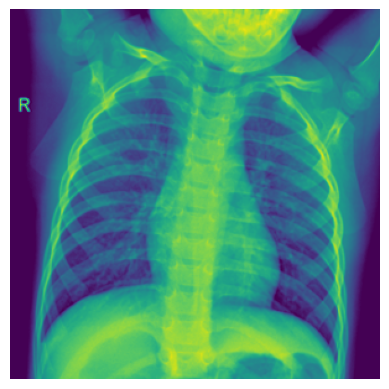

In [6]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [7]:
size = 256 #Image size (depending on model definition)
ratio_val = 0.2 #percentage of dataset to be held into test
batch_size = 210

train_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Création des itérateurs qui chargeront des lots d'images
train, test = train_test_split(df, test_size = ratio_val)

print(f"Number of rows in train set: {len(train)}")

train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="label",
                                                           class_mode = "sparse",
                                                           target_size = (size,size),
                                                           batch_size = batch_size,
                                                           color_mode = "grayscale")

print(f"Number of rows in test set: {len(test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = test,
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = (size,size),
                                                         batch_size = batch_size,
                                                         color_mode = "grayscale",
                                                         shuffle=False) 


Number of rows in train set: 1280
Found 1280 validated image filenames belonging to 4 classes.
Number of rows in test set: 320
Found 320 validated image filenames belonging to 4 classes.


## LeNet Model

In [8]:
# Instanciation modèle séquentiel
lenet = Sequential()

# Ajout des différentes couches
lenet.add(Conv2D(filters = 30 , kernel_size = (5,5), input_shape =[256,256,1], activation = "relu"))
lenet.add(MaxPooling2D(pool_size = (2,2)))

lenet.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu"))
lenet.add(MaxPooling2D(pool_size = (2,2)))

lenet.add(Flatten())
lenet.add(Dropout(rate = 0.2))

lenet.add(Dense(units = 128, activation = "relu"))
lenet.add(Dense(units = 4, activation = "softmax"))

lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 30)      780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 30)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dropout (Dropout)           (None, 61504)             0

In [15]:
# Compilation
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

lenet.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

## Entrainement Modèle

In [10]:
# Entrainement du modèle
train_size = train_generator.samples
test_size = test_generator.samples

epochs = 20

history = lenet.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_size,
                    validation_data = test_generator,
                    validation_steps = test_size // batch_size)

Epoch 1/20
6/6 [==============================] - 44s 8s/step - loss: 811.3638 - accuracy: 0.2673 - val_loss: 160.1378 - val_accuracy: 0.2286
Epoch 2/20
6/6 [==============================] - 23s 3s/step - loss: 58.9193 - accuracy: 0.2523 - val_loss: 15.3708 - val_accuracy: 0.3143
Epoch 3/20
6/6 [==============================] - 21s 3s/step - loss: 10.6521 - accuracy: 0.2841 - val_loss: 2.7967 - val_accuracy: 0.2952
Epoch 4/20
6/6 [==============================] - 23s 3s/step - loss: 1.6669 - accuracy: 0.3093 - val_loss: 1.3603 - val_accuracy: 0.3667
Epoch 5/20
6/6 [==============================] - 21s 3s/step - loss: 1.2246 - accuracy: 0.5065 - val_loss: 1.1940 - val_accuracy: 0.4905
Epoch 6/20
6/6 [==============================] - 21s 3s/step - loss: 0.9993 - accuracy: 0.5888 - val_loss: 1.0622 - val_accuracy: 0.5762
Epoch 7/20
6/6 [==============================] - 22s 3s/step - loss: 0.7779 - accuracy: 0.6916 - val_loss: 0.9966 - val_accuracy: 0.6238
Epoch 8/20
6/6 [===========

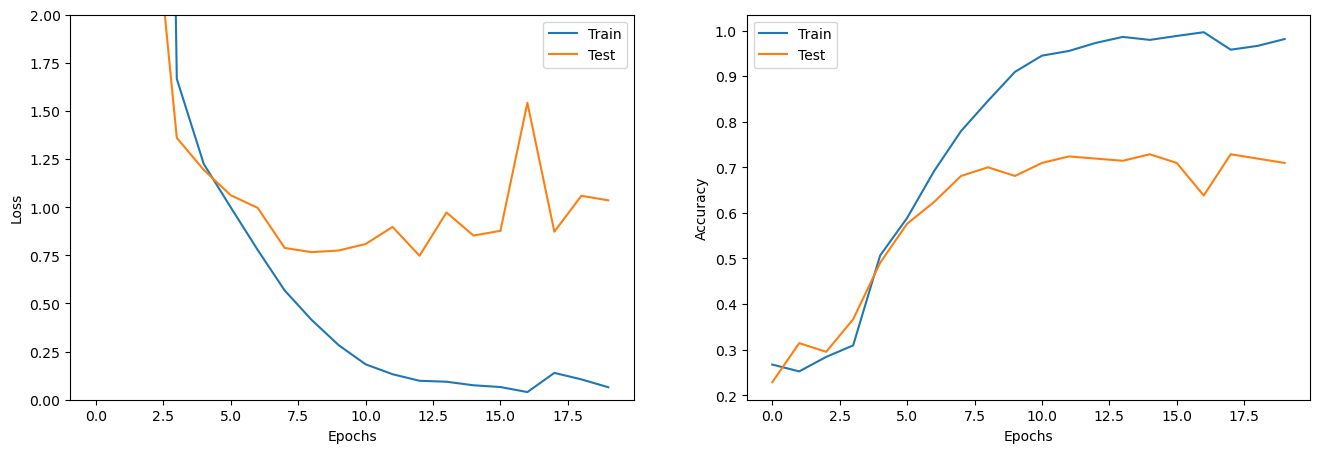

In [11]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance 

In [12]:
# Prédictions (probabilités)
test_generator.reset()
test_pred_lenet = lenet.predict(test_generator, verbose = 1 )

2/2 [==============================] - 4s 505ms/step


In [13]:
# Récupération des classes à partir des probabilités
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)

# Matrice de confusion
print(confusion_matrix(test_generator.classes, test_pred_lenet_class))

[[54  6  5 13]
 [13 60  1 13]
 [ 7  0 61  6]
 [19 17  2 43]]


In [14]:
print(classification_report(test_generator.classes, test_pred_lenet_class, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63        78
           1       0.72      0.69      0.71        87
           2       0.88      0.82      0.85        74
           3       0.57      0.53      0.55        81

    accuracy                           0.68       320
   macro avg       0.69      0.68      0.69       320
weighted avg       0.69      0.68      0.68       320

